# Effects of $\alpha$ and $\lambda$ parameter

In all SI architectures, there are two weights in the loss function -- $\alpha$, which multiplies the reconstruction MSE (the standard autoencoder loss) and $\lambda$, which multiplies the regularization term, which in AECross is the cross-prediction MSE.

In this notebook, we explore the effects of different choices of $\lambda$ and $\alpha$ on the MNIST estimation problem.

In [1]:
%%capture
import time
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

from lmi import lmi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm

from scipy.stats import kendalltau

from keras.datasets import mnist

import torch

torch.manual_seed(2121)
np.random.seed(2121)

In [2]:
def generate_gaussian_dataset(ambient, intrinsic, nuisance, antidiag, samples=10**3):
    
    assert intrinsic+nuisance <= ambient, "Dimensionality not adding up"
    
    X_nuisance = np.random.normal(size=(samples, nuisance))
    Y_nuisance = np.random.normal(size=(samples, nuisance))


    cov = np.array([[6, antidiag], [antidiag, 3.5]])
    
    pts = [np.random.multivariate_normal([0, 0], cov, 
                                         size=samples) for i in range(intrinsic)]
    
    pts = np.hstack(pts)
    
    # one copy of the intrinsic dimensions
    Xs = pts[:, [i for i in range(0, 2*intrinsic, 2)]]
    Ys = pts[:, [i for i in range(1, 2*intrinsic, 2)]]
    
    # then randomly sample them to make up the rest of the dimensions
    X_redundant = pts[:, np.random.choice(range(0, 2*intrinsic, 2), 
                                   size = (ambient-(intrinsic+nuisance)))]
    
    Y_redundant = pts[:, np.random.choice(range(1, 2*intrinsic, 2), 
                               size = (ambient-(intrinsic+nuisance)))]
    
    Xs = np.hstack((Xs, X_redundant, X_nuisance))
    Ys = np.hstack((Ys, Y_redundant, Y_nuisance))
    
    return Xs, Ys

def mi_from_rho(rho, intrinsic):
    return -0.5*np.log2((1-(rho/(np.sqrt(6*3.5)))**2))*intrinsic

def rho_from_mi(mi, intrinsic):
    return np.sqrt(6*3.5) * np.sqrt(1 - 2**(-2*mi/intrinsic))

In [3]:
np.seterr(divide='ignore', invalid='ignore')

smi_d = {
    "Estimate" : [],
    "True MI" : [],
    "Regularizer" : [],
    "Alpha" : [],
    "Lambda" : [],
    "Time" : [],
    }

for ps in tqdm(np.linspace(0, 1, 100)):
    
    antidiag = rho_from_mi(ps, 1)
    Xs, Ys = generate_gaussian_dataset(100, 1, 98, antidiag)
    
    Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
    Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))
    
    
    for regularizer in ['models.AECross',
                       'models.AEMINE',
                       'models.AEInfoNCE']:
        
        for alpha, lam in [(1, 0), (0, 1), (1, 1)]:
            t0 = time.time()
            estimate, embedding, model = lmi.lmi(Xs, Ys, N_dims=8,
                                                  regularizer=regularizer,
                                                  alpha=alpha, lam=lam)
            smi_d["Estimate"].append(np.mean(np.nanmean(estimate)))
            t1 = time.time()
            smi_d["True MI"].append(ps)
            smi_d["Regularizer"].append(regularizer)
            smi_d['Alpha'].append(alpha)
            smi_d['Lambda'].append(lam)
            smi_d["Time"].append(t1-t0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
smi_df = pd.DataFrame(smi_d)
g = smi_df.groupby(['Alpha', 'Lambda', 'Regularizer'])
def kendall(group):
    t = group['True MI']
    e = group['Estimate']
    return kendalltau(t, e)[0]

def mse(group):
    t = group['True MI']
    e = group['Estimate']
    return np.mean((t-e)**2)

In [5]:
k = g.apply(mse).unstack().fillna(0)
k

Regularizer   models.AECross  models.AEInfoNCE  models.AEMINE
Alpha Lambda                                                 
0     1             0.005580          0.004948       0.006153
1     0             0.005236          0.004479       0.004823
      1             0.004443          0.005158       0.005256

In [6]:
k = g.apply(kendall).unstack().fillna(0)
k


Regularizer   models.AECross  models.AEInfoNCE  models.AEMINE
Alpha Lambda                                                 
0     1             0.866263          0.862222       0.866667
1     0             0.854141          0.878384       0.862222
      1             0.868283          0.862222       0.847273

In [7]:
smi_df.to_csv('../results/B_regularization_effect.csv')

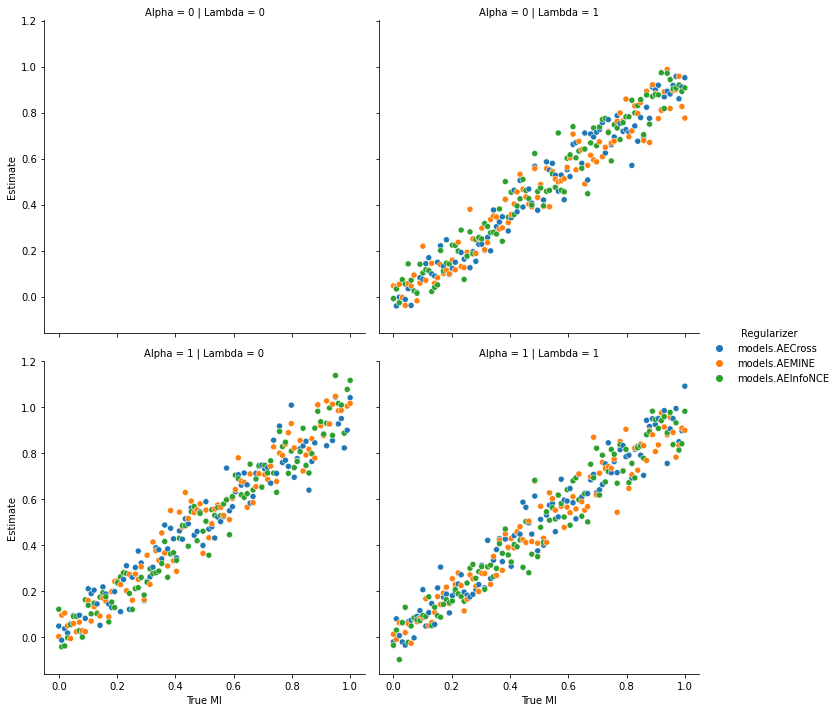

In [8]:
sns.relplot(smi_df, x = "True MI", 
                y="Estimate", 
                hue="Regularizer",
               row='Alpha', col='Lambda')